# Gaussian processes

Notebook exploring how Gaussian processes could be applied to spirals.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
import tqdm
import torch
import gpytorch

## Option A - model selection and kernel tuning
I will compare the learned parameters across classes for diagnostic signatures for anomalies

In [2]:
def normalize_r(r):
    """Function that normalizes the radius values

    Args:
        r (array like): array of radius values

    Returns:
        r_normalized (Numpay array): normalized array of radius values
        mean (float): mean of the original radius values
        std (float): standard deviation of the original radius values
    """
    
    mean = np.mean(r)
    std = np.std(r)
    r_normalized = (r - mean) / std
    return r_normalized, mean, std

In [3]:
class SpiralGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, period=2*np.pi):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        # Periodic: angular structure with known period
        per = gpytorch.kernels.PeriodicKernel()
        per.lengthscale = 0.5
        per.register_constraint("raw_lengthscale",
                                gpytorch.constraints.Interval(0.1, 2.0))

        # Linear: radial growth with angle
        lin = gpytorch.kernels.LinearKernel()
        # (Optionally constrain lin variance if needed)
        # lin.register_constraint("raw_variance",
        #                         gpytorch.constraints.Interval(1e-4, 10.0))

        # RBF: local non-periodic variations (e.g., spikiness)
        rbf = gpytorch.kernels.RBFKernel()
        rbf.lengthscale = 0.5
        rbf.register_constraint("raw_lengthscale",
                                gpytorch.constraints.Interval(0.05, 3.0))

        # Final kernel: (periodic pattern whose amplitude changes with theta) + smooth residuals
        base = (per * lin) + rbf

        self.covar_module = gpytorch.kernels.ScaleKernel(base)
        self.covar_module.outputscale = 1.0
        self.covar_module.register_constraint("raw_outputscale",
                                              gpytorch.constraints.Interval(0.1, 5.0))

    def forward(self, x):
        mean_x  = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [4]:
import math

def extract_params(model, likelihood):
    # base could be AdditiveKernel((ProductKernel(per, lin)), RBF)
    base = model.covar_module.base_kernel
    if hasattr(base, "kernels") and len(base.kernels) == 2:
        prod = base.kernels[0]   # ProductKernel
        rbf  = base.kernels[1]   # RBFKernel
        if hasattr(prod, "kernels") and len(prod.kernels) == 2:
            per = prod.kernels[0]
            lin = prod.kernels[1]
        else:
            raise RuntimeError("Expected ProductKernel(per, lin) as first term.")
    else:
        # fallback: maybe you removed RBF and only have ProductKernel(per, lin)
        prod = base
        if hasattr(prod, "kernels") and len(prod.kernels) == 2:
            per = prod.kernels[0]
            lin = prod.kernels[1]
            rbf = None
        else:
            raise RuntimeError("Kernel tree not recognized. Print model.covar_module.base_kernel to inspect.")

    out = {
        "lengthscale_per": float(per.lengthscale.detach().cpu()),
        "variance_lin":    float(lin.variance.detach().cpu()),
        "sigma_f":         float(model.covar_module.outputscale.detach().cpu()),
        "sigma_n":         float(likelihood.noise.detach().cpu()),
    }
    if rbf is not None:
        out["lengthscale_rbf"] = float(rbf.lengthscale.detach().cpu())
    return out

def prep_theta_r(theta, r, force_period=2*math.pi):
    # to numpy
    theta = np.asarray(theta, dtype=np.float64).reshape(-1)
    r     = np.asarray(r,     dtype=np.float64).reshape(-1)

    # standardize r per spiral (avoid divide-by-zero)
    r_min = r.min()
    r_std  = r.std() if r.std() > 1e-12 else 1.0
    r_norm = (r - r_min) / r_std

    x = torch.as_tensor(theta, dtype=torch.float64)
    y = torch.as_tensor(r_norm,     dtype=torch.float64).reshape(-1)
    return x, y, (r_min, r_std)


def fit_gp(theta, r, learning_rate=0.05, epochs=150):
    x, y, norm_stats = prep_theta_r(theta, r)

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    likelihood.noise = 1e-2
    likelihood.noise_covar.register_constraint("raw_noise",
                                               gpytorch.constraints.Interval(1e-5, 1e-2))
    model = SpiralGP(x, y, likelihood, period=2*math.pi)

    model.train(); likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for _ in range(epochs):
        optimizer.zero_grad()
        with gpytorch.settings.cholesky_jitter(1e-3):
            output = model(x)
            loss = -mll(output, y)
        loss.backward()
        optimizer.step()

    params = extract_params(model, likelihood)
    
    return params, model, likelihood

### Training

In [5]:
## Load the data
data_folder = "./syn_data/flat/"
files = list(Path(data_folder).glob("*.csv"))
data = []
for f in files:
    df = pd.read_csv(f)[['theta', 'r']].astype('float64')
    theta, r = df['theta'].values, df['r'].values
    
    indices = np.random.choice(len(theta), size=60, replace=False)
    indices = sorted(indices)
    theta = [theta[i] for i in indices]
    r = [r[i] for i in indices]
        
    spiral = [(t_i, r_i) for t_i, r_i in zip(theta, r)]
    data.append(spiral)
    
# sample 100 random indices from data
indices = np.random.choice(len(data), size=100, replace=False)
indices = sorted(indices)
train_data = [data[i] for i in indices]

In [6]:
def train(data, epochs=150):
    gp_params = []
    models, likelihoods = [], []
    for spiral in tqdm.tqdm(data, desc="Training GP models"):
        theta = [point[0] for point in spiral]
        r = [point[1] for point in spiral]
        
        params, model, likelihood = fit_gp(theta, r, epochs=epochs)
        gp_params.append(params)
        models.append(model)
        likelihoods.append(likelihood)
        
    return gp_params, models, likelihoods

In [7]:
gp_params, models, likelihoods = train(train_data, epochs=150)

Training GP models:   0%|          | 0/100 [00:00<?, ?it/s]

Training GP models: 100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


In [8]:
print(models[0].covar_module.base_kernel)

AdditiveKernel(
  (kernels): ModuleList(
    (0): ProductKernel(
      (kernels): ModuleList(
        (0): PeriodicKernel(
          (raw_lengthscale_constraint): Interval(1.000E-01, 2.000E+00)
          (raw_period_length_constraint): Positive()
        )
        (1): LinearKernel(
          (raw_variance_constraint): Positive()
        )
      )
    )
    (1): RBFKernel(
      (raw_lengthscale_constraint): Interval(5.000E-02, 3.000E+00)
    )
  )
)


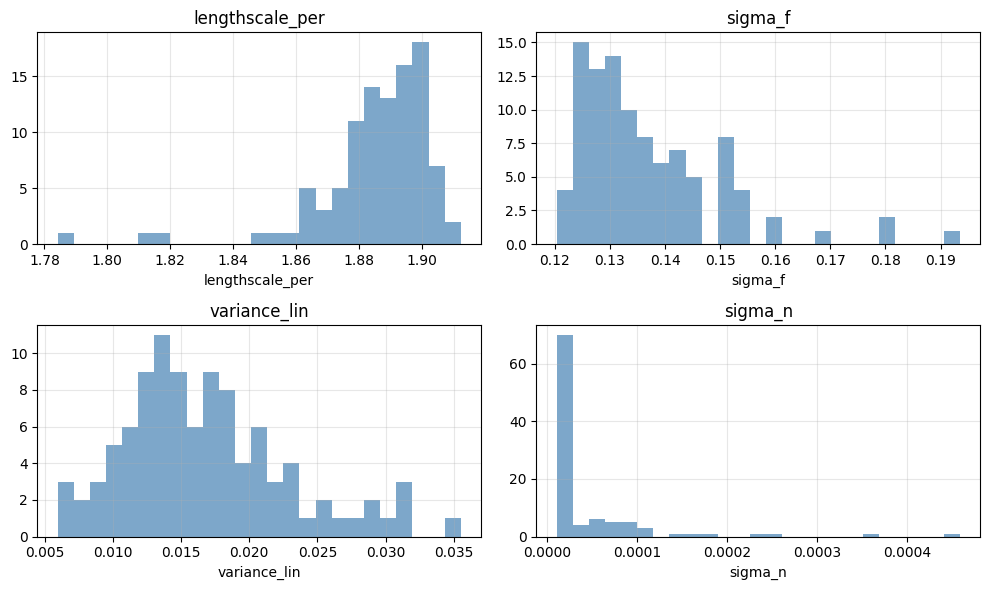

       lengthscale_per     sigma_f  variance_lin     sigma_n  lengthscale_rbf
count       100.000000  100.000000    100.000000  100.000000       100.000000
mean          1.885436    0.137020      0.016844    0.000044         1.006355
std           0.019351    0.013146      0.006144    0.000070         0.520953
min           1.784148    0.120309      0.005944    0.000011         0.668646
25%           1.879233    0.127333      0.012759    0.000011         0.760177
50%           1.890224    0.132826      0.015493    0.000015         0.829725
75%           1.897289    0.143502      0.019923    0.000051         0.955474
max           1.912444    0.193507      0.035514    0.000459         2.831958


In [9]:
df = pd.DataFrame(gp_params)   # only this class
cols = ["lengthscale_per", "sigma_f", "variance_lin", "sigma_n", "lengthscale_rbf"]

fig, axes = plt.subplots(2, 2, figsize=(10,6))
for ax, col in zip(axes.ravel(), cols):
    ax.hist(df[col], bins=25, color="steelblue", alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel(col); ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

print(df[cols].describe())

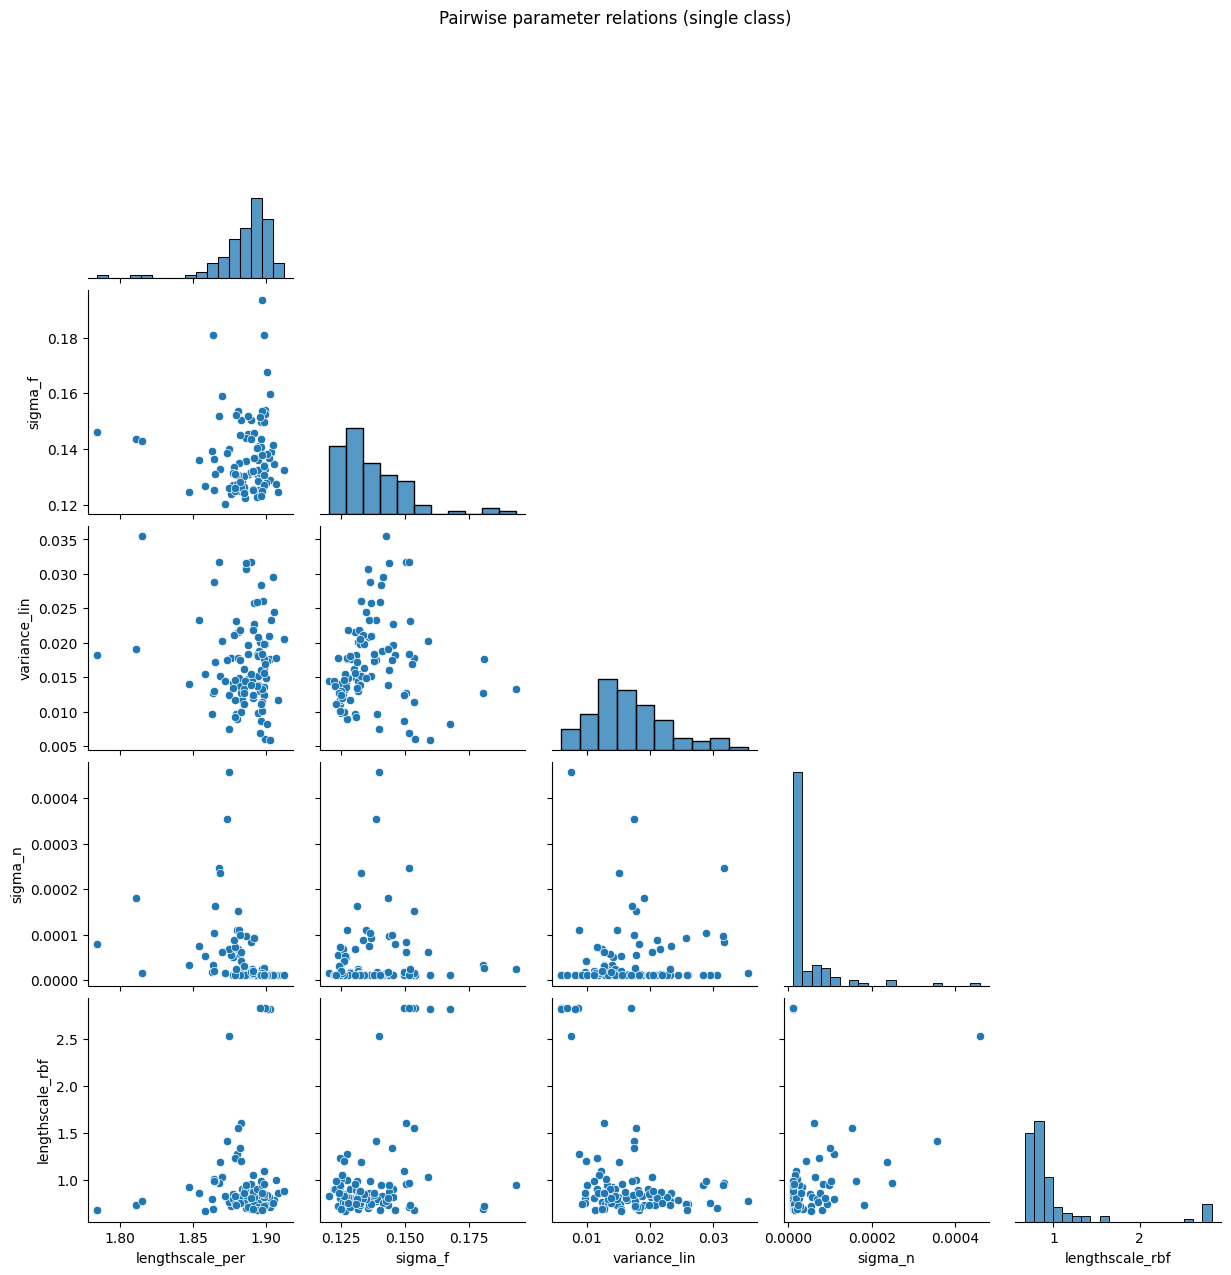

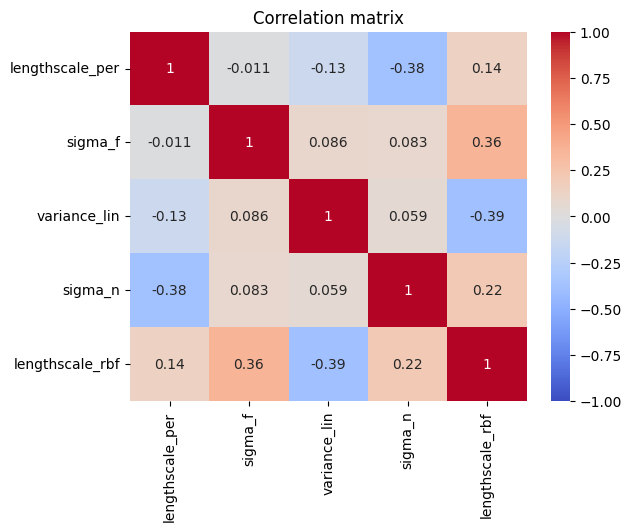

In [10]:
import seaborn as sns
sns.pairplot(df[cols], corner=True)
plt.suptitle("Pairwise parameter relations (single class)", y=1.02)
plt.show()

sns.heatmap(df[cols].corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation matrix"); plt.show()

In [34]:
def plot_posterior(theta, r_norm, model, likelihood, n_test=400, title=""):
    """
    Visualize GP posterior for a single spiral.

    Parameters
    ----------
    theta : array-like
        Training input angles (1D or Nx1 tensor).
    r_norm : array-like
        Normalized training radii.
    model : gpytorch.models.ExactGP
        Trained GP model.
    likelihood : gpytorch.likelihoods.GaussianLikelihood
        Associated likelihood.
    n_test : int
        Number of points to plot in test grid.
    title : str
        Plot title.
    """

    model.eval(); likelihood.eval()

    # ensure tensors
    theta_t = torch.as_tensor(theta, dtype=torch.get_default_dtype()).view(-1, 1)
    r_t = torch.as_tensor(r_norm, dtype=torch.get_default_dtype())

    # create dense grid for prediction
    t_min, t_max = float(theta_t.min()), float(theta_t.max())
    test_x = torch.linspace(t_min, t_max, n_test, dtype=theta_t.dtype).view(-1, 1)

    # predictive distribution
    with torch.no_grad():
        pred = likelihood(model(test_x))
    mean = pred.mean.cpu().numpy().flatten()
    std  = pred.stddev.cpu().numpy().flatten()
    tx   = test_x.cpu().numpy().flatten()

    # plot
    plt.figure(figsize=(7,4))
    plt.plot(theta_t, r_t, "k.", ms=4, alpha=0.7, label="train points")
    plt.plot(tx, mean, "r", lw=2, label="GP mean")
    plt.fill_between(tx, mean-2*std, mean+2*std, color="r", alpha=0.2, label="±2σ")
    plt.title(title)
    plt.xlabel("θ"); plt.ylabel("normalized r")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [35]:
def plot_posterior_polar(theta, r_norm, model, likelihood, n_test=400, title=""):
    """
    Visualize GP posterior for a single spiral.
    """

    model.eval(); likelihood.eval()

    # ensure tensors
    theta_t = torch.as_tensor(theta, dtype=torch.get_default_dtype()).view(-1, 1)
    r_t = torch.as_tensor(r_norm, dtype=torch.get_default_dtype())

    # create dense grid for prediction
    t_min, t_max = float(theta_t.min()), float(theta_t.max())
    test_x = torch.linspace(t_min, t_max, n_test, dtype=theta_t.dtype).view(-1, 1)

    # predictive distribution
    with torch.no_grad():
        pred = likelihood(model(test_x))
    mean = pred.mean.cpu().numpy().flatten()
    std  = pred.stddev.cpu().numpy().flatten()
    tx   = test_x.cpu().numpy().flatten()

    # polar plot
    fig = plt.figure(figsize=(7, 4))
    ax = fig.add_subplot(111, projection="polar")

    # training data

    # posterior mean
    ax.plot(tx, mean, "firebrick", lw=1, label="GP mean")

    # uncertainty bounds (dashed)
    ax.plot(tx, mean + 2*std, "r--", lw=1, alpha=0.6)
    ax.plot(tx, mean - 2*std, "r--", lw=1, alpha=0.6)

    ax.plot(theta_t.cpu(), r_t.cpu(), "k.", ms=4, alpha=0.6, label="train points")
    ax.set_title(title)
    ax.grid(True, alpha=0.25)
    ax.legend(loc="upper right", bbox_to_anchor=(1.1, 1.1))
    plt.tight_layout()
    plt.show()

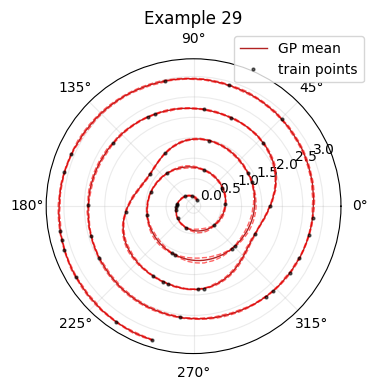

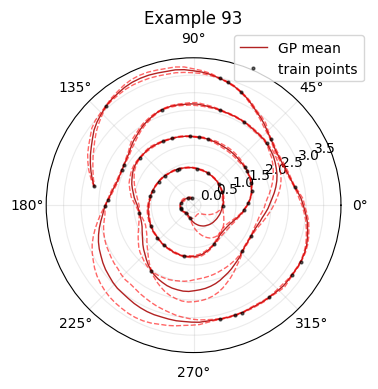

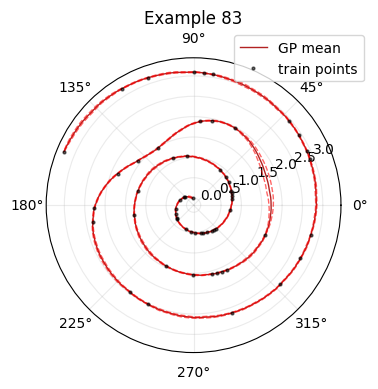

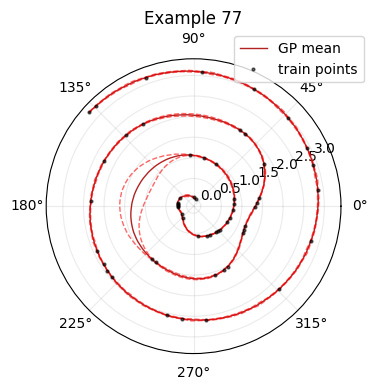

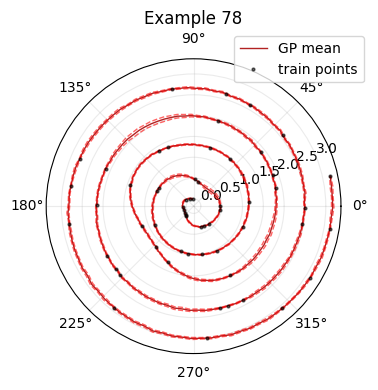

In [37]:
import random
indices = random.sample(range(len(train_data)), 5)
for idx in indices:
    theta, r = zip(*train_data[idx])
    plot_posterior_polar(theta, (r - np.min(r))/np.std(r), models[idx], likelihoods[idx],
                   title=f"Example {idx}")
